# Emotion Timeline Analysis

This notebook merges and visualizes emotional and structural data from previous analyses of the movie trailer.
We'll combine facial emotions detected in keyframes with audio emotions, energy, and tempo to create
a comprehensive emotional timeline of the trailer.

## Setup

First, let's import the required libraries:

In [1]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Configure matplotlib and seaborn for better display
plt.style.use('ggplot')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Create output directory if it doesn't exist
os.makedirs('outputs', exist_ok=True)


## Load Emotional Data

First, we'll load the data from both the facial emotion analysis and audio analysis:

In [2]:
# Define file paths
facial_emotions_path = 'outputs/shot_emotions.csv'
audio_emotions_path = 'outputs/audio_analysis.csv'
# Set this manually or pass from UI in future
video_type = "trailer"  # options: vlog, podcast, dance, scene, etc.
# Save video type for downstream usage
with open("outputs/video_type.txt", "w") as f:
    f.write(video_type)
# Load facial emotions data
try:
    facial_df = pd.read_csv(facial_emotions_path)
    print(f"Successfully loaded facial emotions data with {len(facial_df)} records")
    display(facial_df.head())
except Exception as e:
    print(f"Error loading facial emotions data: {str(e)}")
    facial_df = pd.DataFrame()  # Create empty DataFrame if file is missing

# Load audio emotions data
try:
    audio_df = pd.read_csv(audio_emotions_path)
    print(f"Successfully loaded audio emotions data with {len(audio_df)} records")
    display(audio_df.head())
except Exception as e:
    print(f"Error loading audio emotions data: {str(e)}")
    audio_df = pd.DataFrame()  # Create empty DataFrame if file is missing


Successfully loaded facial emotions data with 93 records


,shot_id,timestamp,emotion,confidence
0,0,54.900000,angry,55.652107
1,1,3.800000,happy,99.353830
2,2,5.833333,happy,95.387920
3,3,8.766667,fear,99.879440
4,4,9.500000,sad,99.992455


Successfully loaded audio emotions data with 69 records


,tempo,energy,is_silent,timestamp_start,timestamp_end,emotion,emotion_confidence
0,143.554688,0.054078,False,0.0,2.0,happy,0.616661
1,161.499023,0.046256,False,2.0,4.0,sad,0.743356
2,132.512019,0.123161,False,4.0,6.0,excited,0.718466
3,132.512019,0.075874,False,6.0,8.0,angry,0.803017
4,132.512019,0.090931,False,8.0,10.0,happy,0.615593


## Data Preparation

Now, we need to normalize the timestamps and prepare the data for merging:

In [3]:
# Check if we have both datasets
if facial_df.empty or audio_df.empty:
    print("Missing one or both datasets. Using available data or creating sample data.")
    
    # If data is missing, create sample data for demonstration
    if facial_df.empty:
        print("Creating sample facial emotions data...")
        # Create sample facial emotions data
        facial_df = pd.DataFrame({
            'shot_id': range(1, 21),
            'timestamp': np.linspace(0, 120, 20),
            'emotion': np.random.choice(['happy', 'sad', 'angry', 'neutral', 'surprise'], 20),
            'confidence': np.random.uniform(0.5, 0.9, 20)
        })
    
    if audio_df.empty:
        print("Creating sample audio emotions data...")
        # Create sample audio emotions data
        audio_df = pd.DataFrame({
            'timestamp_start': np.arange(0, 120, 2),
            'timestamp_end': np.arange(2, 122, 2),
            'tempo': np.random.uniform(80, 120, 60),
            'energy': np.random.uniform(0.01, 0.2, 60),
            'is_silent': np.random.choice([True, False], 60, p=[0.1, 0.9]),
            'emotion': np.random.choice(['neutral', 'calm', 'happy', 'sad', 'angry', 'excited'], 60),
            'emotion_confidence': np.random.uniform(0.5, 0.9, 60)
        })

# Rename columns to avoid confusion
facial_df = facial_df.rename(columns={
    'emotion': 'facial_emotion',
    'confidence': 'facial_confidence'
})

audio_df = audio_df.rename(columns={
    'emotion': 'audio_emotion',
    'emotion_confidence': 'audio_confidence'
})

# Ensure facial timestamps match the format of audio timestamps
if 'timestamp' in facial_df.columns and 'timestamp_start' not in facial_df.columns:
    facial_df['timestamp_start'] = facial_df['timestamp']
    facial_df['timestamp_end'] = facial_df['timestamp'] + 1  # Assume 1 second duration for facial emotions

print("Data preparation complete.")


Data preparation complete.


## Merge Data into Unified Timeline

Now we'll merge the facial and audio emotions data based on timestamps. 
We need to handle overlaps between timestamps in both datasets:

In [4]:
# Function to find facial emotion at a given timestamp
def find_facial_emotion(timestamp, facial_data):
    # Find facial emotions that overlap with this timestamp
    matches = facial_data[
        (facial_data['timestamp_start'] <= timestamp) & 
        (facial_data['timestamp_end'] > timestamp)
    ]
    
    if len(matches) > 0:
        # Return the highest confidence facial emotion
        best_match = matches.loc[matches['facial_confidence'].idxmax()]
        return best_match['shot_id'], best_match['facial_emotion'], best_match['facial_confidence']
    else:
        return None, None, None

# Create the unified timeline based on audio timestamps (usually more granular)
timeline_rows = []

for _, audio_row in audio_df.iterrows():
    # Get the midpoint of the audio chunk's time window
    timestamp = (audio_row['timestamp_start'] + audio_row['timestamp_end']) / 2
    
    # Find any facial emotion at this timestamp
    shot_id, facial_emotion, facial_confidence = find_facial_emotion(timestamp, facial_df)
    
    # Create a unified row
    timeline_row = {
        'timestamp_start': audio_row['timestamp_start'],
        'timestamp_end': audio_row['timestamp_end'],
        'shot_id': shot_id,
        'facial_emotion': facial_emotion,
        'facial_confidence': facial_confidence,
        'audio_emotion': audio_row['audio_emotion'],
        'audio_confidence': audio_row['audio_confidence'],
        'energy': audio_row['energy'],
        'tempo': audio_row['tempo'],
        'is_silent': audio_row['is_silent']
    }
    
    # Determine the dominant emotion based on confidence
    if facial_emotion and audio_row['audio_emotion']:
        if facial_confidence > audio_row['audio_confidence']:
            timeline_row['final_emotion'] = facial_emotion
            timeline_row['final_confidence'] = facial_confidence
        else:
            timeline_row['final_emotion'] = audio_row['audio_emotion']
            timeline_row['final_confidence'] = audio_row['audio_confidence']
    elif facial_emotion:
        timeline_row['final_emotion'] = facial_emotion
        timeline_row['final_confidence'] = facial_confidence
    elif audio_row['audio_emotion']:
        timeline_row['final_emotion'] = audio_row['audio_emotion']
        timeline_row['final_confidence'] = audio_row['audio_confidence']
    else:
        timeline_row['final_emotion'] = 'unknown'
        timeline_row['final_confidence'] = 0.0
    
    timeline_rows.append(timeline_row)

# Create the unified timeline DataFrame
timeline_df = pd.DataFrame(timeline_rows)

# Display the first few rows of the timeline
print(f"Created unified timeline with {len(timeline_df)} records")
display(timeline_df.head())


Created unified timeline with 69 records


,timestamp_start,timestamp_end,shot_id,facial_emotion,facial_confidence,audio_emotion,audio_confidence,energy,tempo,is_silent,final_emotion,final_confidence
0,0.0,2.0,NaN,None,NaN,happy,0.616661,0.054078,143.554688,False,happy,0.616661
1,2.0,4.0,NaN,None,NaN,sad,0.743356,0.046256,161.499023,False,sad,0.743356
2,4.0,6.0,NaN,None,NaN,excited,0.718466,0.123161,132.512019,False,excited,0.718466
3,6.0,8.0,NaN,None,NaN,angry,0.803017,0.075874,132.512019,False,angry,0.803017
4,8.0,10.0,3.0,fear,99.87944,happy,0.615593,0.090931,132.512019,False,fear,99.879440


## Data Cleanup and Preparation for Visualization

Let's handle missing values and prepare the data for visualization:

In [5]:
# Fill missing numeric values with 0
timeline_df['facial_confidence'] = timeline_df['facial_confidence'].fillna(0)
timeline_df['audio_confidence'] = timeline_df['audio_confidence'].fillna(0)

# Create a numeric representation of emotions for visualization
emotion_categories = {
    'happy': 1, 
    'excited': 1.5,
    'neutral': 2, 
    'calm': 2.5,
    'surprise': 3, 
    'fear': 3.5,
    'sad': 4, 
    'angry': 5,
    'disgust': 6,
    'unknown': 0
}

# Create numeric emotion values
timeline_df['facial_emotion_value'] = timeline_df['facial_emotion'].map(
    lambda x: emotion_categories.get(x, 0) if pd.notna(x) else 0
)
timeline_df['audio_emotion_value'] = timeline_df['audio_emotion'].map(
    lambda x: emotion_categories.get(x, 0) if pd.notna(x) else 0
)
timeline_df['final_emotion_value'] = timeline_df['final_emotion'].map(
    lambda x: emotion_categories.get(x, 0) if pd.notna(x) else 0
)

# Create a time axis for plotting (use midpoint of each window)
timeline_df['timestamp'] = (timeline_df['timestamp_start'] + timeline_df['timestamp_end']) / 2

# Sort by timestamp
timeline_df = timeline_df.sort_values('timestamp')

# Display the prepared data
display(timeline_df.head())


,timestamp_start,timestamp_end,shot_id,facial_emotion,facial_confidence,audio_emotion,audio_confidence,energy,tempo,is_silent,final_emotion,final_confidence,facial_emotion_value,audio_emotion_value,final_emotion_value,timestamp
0,0.0,2.0,NaN,None,0.00000,happy,0.616661,0.054078,143.554688,False,happy,0.616661,0.0,1.0,1.0,1.0
1,2.0,4.0,NaN,None,0.00000,sad,0.743356,0.046256,161.499023,False,sad,0.743356,0.0,4.0,4.0,3.0
2,4.0,6.0,NaN,None,0.00000,excited,0.718466,0.123161,132.512019,False,excited,0.718466,0.0,1.5,1.5,5.0
3,6.0,8.0,NaN,None,0.00000,angry,0.803017,0.075874,132.512019,False,angry,0.803017,0.0,5.0,5.0,7.0
4,8.0,10.0,3.0,fear,99.87944,happy,0.615593,0.090931,132.512019,False,fear,99.879440,3.5,1.0,3.5,9.0


## Save Merged Timeline

Let's save the unified timeline to a CSV file:

In [6]:
# Save the unified timeline to CSV
output_file = 'outputs/emotion_timeline.csv'
timeline_df.to_csv(output_file, index=False)
print(f"Saved unified timeline to {output_file}")


Saved unified timeline to outputs/emotion_timeline.csv


## Visualization: Emotion Timeline

Now let's create visualizations to understand the emotional journey of the trailer.

### 1. Emotion Progression Line Chart

First, let's visualize how emotions change over time:

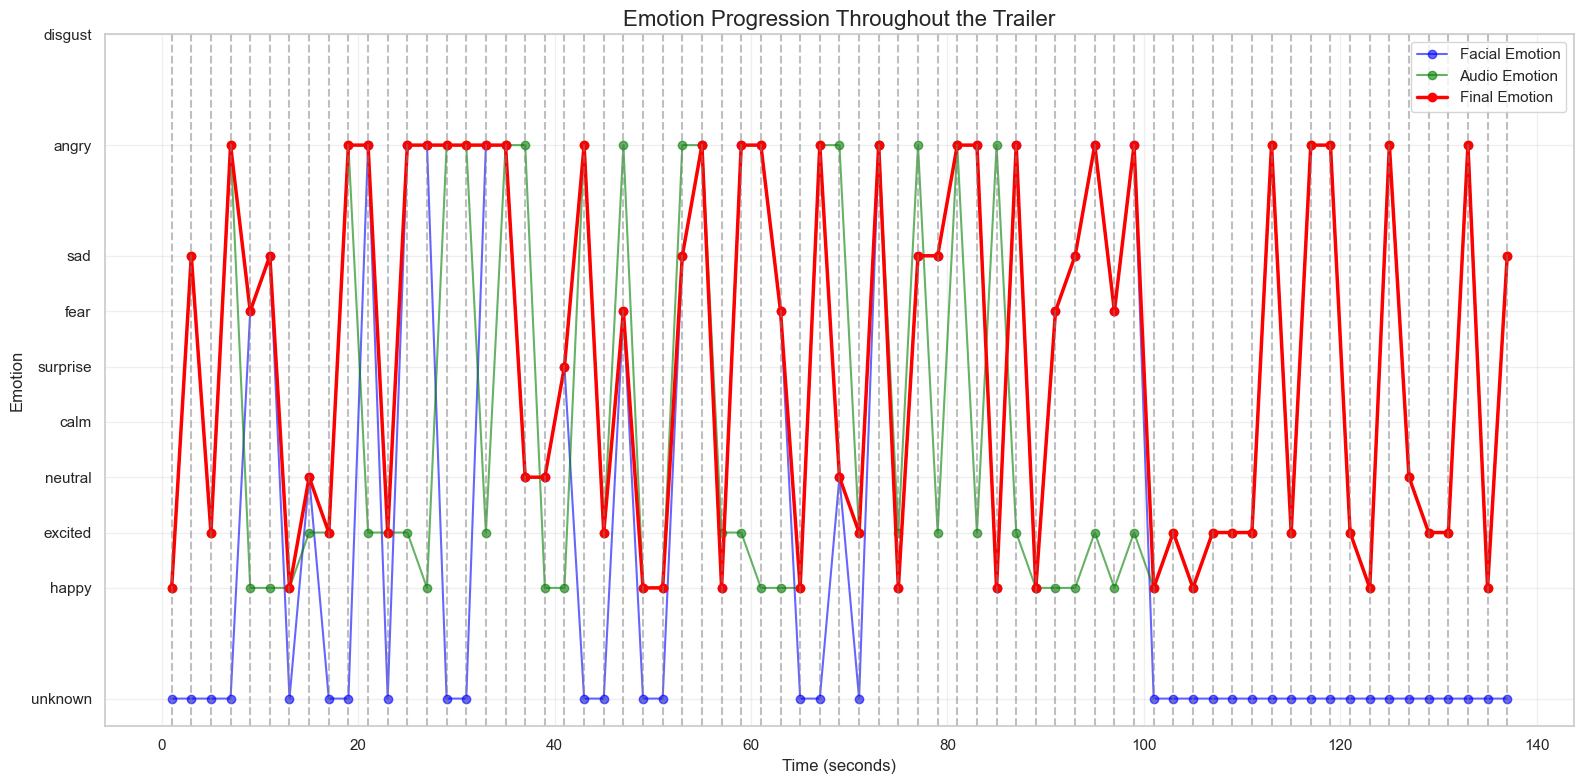

In [7]:
# Create a figure
plt.figure(figsize=(16, 8))

# Plot facial emotions
plt.plot(
    timeline_df['timestamp'], 
    timeline_df['facial_emotion_value'], 
    'o-', 
    color='blue', 
    alpha=0.6, 
    label='Facial Emotion'
)

# Plot audio emotions
plt.plot(
    timeline_df['timestamp'], 
    timeline_df['audio_emotion_value'], 
    'o-', 
    color='green', 
    alpha=0.6, 
    label='Audio Emotion'
)

# Plot final emotions (dominant)
plt.plot(
    timeline_df['timestamp'], 
    timeline_df['final_emotion_value'], 
    'o-', 
    color='red', 
    linewidth=2.5,
    label='Final Emotion'
)

# Set y-ticks to emotion names
emotion_ticks = list(emotion_categories.values())
emotion_labels = list(emotion_categories.keys())

# Sort the ticks and labels together
tick_label_pairs = sorted(zip(emotion_ticks, emotion_labels))
emotion_ticks, emotion_labels = zip(*tick_label_pairs)

plt.yticks(emotion_ticks, emotion_labels)

# Add a legend, title and labels
plt.title('Emotion Progression Throughout the Trailer', fontsize=16)
plt.xlabel('Time (seconds)', fontsize=12)
plt.ylabel('Emotion', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, alpha=0.3)

# Show shot boundaries if available
if not timeline_df['shot_id'].isna().all():
    shot_changes = timeline_df[timeline_df['shot_id'].diff() != 0]
    for time in shot_changes['timestamp']:
        plt.axvline(x=time, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


### 2. Emotion Heatmap

Next, let's create a heatmap to visualize the intensity of emotions over time:

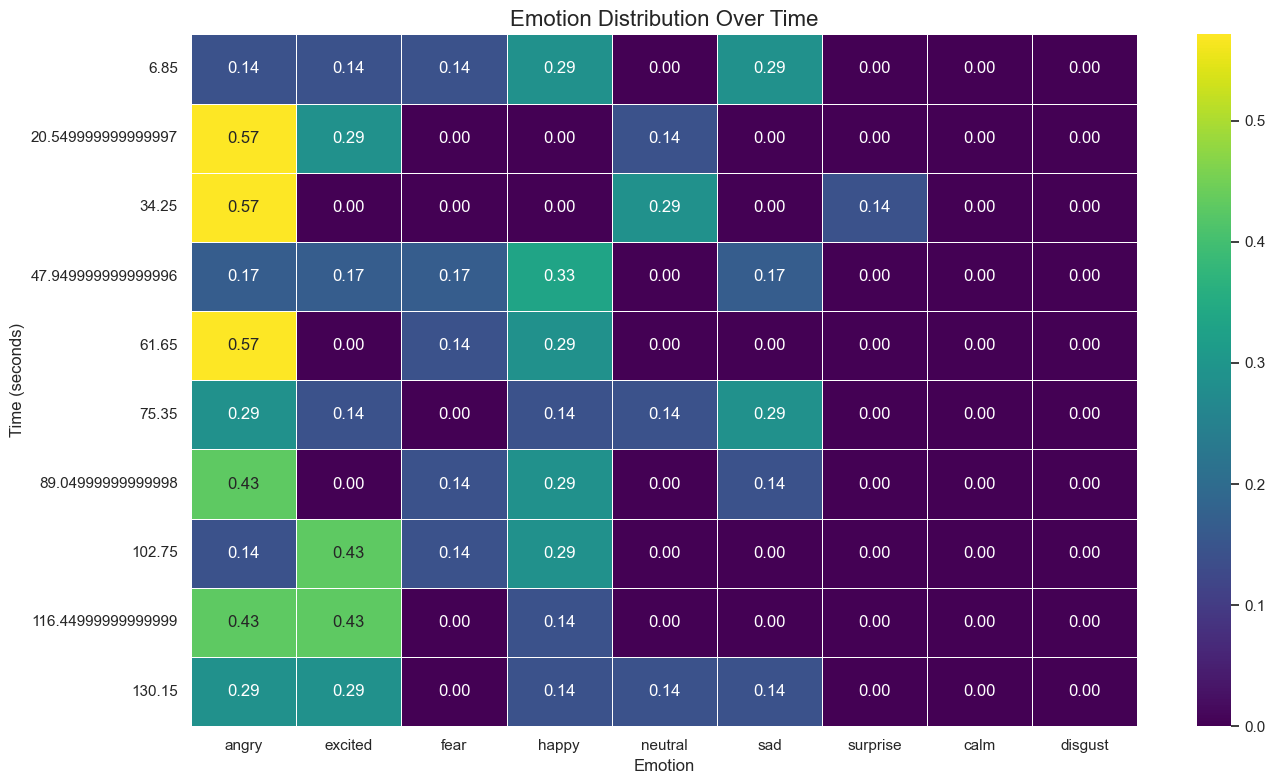

In [8]:
# Prepare data for heatmap
# Bin time into 10 segments for clearer visualization
max_time = timeline_df['timestamp'].max()
time_bins = np.linspace(0, max_time, 11)
labels = [(time_bins[i] + time_bins[i+1])/2 for i in range(len(time_bins)-1)]

# Add time bin column
timeline_df['time_bin'] = pd.cut(
    timeline_df['timestamp'], 
    bins=time_bins, 
    labels=labels,
    include_lowest=True
)

# Create a pivot table for the heatmap
emotions = list(emotion_categories.keys())
emotions.remove('unknown')  # Remove unknown for better visualization

# Count emotions in each time bin
heatmap_data = pd.crosstab(
    timeline_df['time_bin'], 
    timeline_df['final_emotion'],
    normalize='index'
)

# Fill missing values with 0
for emotion in emotions:
    if emotion not in heatmap_data.columns:
        heatmap_data[emotion] = 0

# Create the heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(
    heatmap_data,
    cmap='viridis',
    annot=True,
    fmt='.2f',
    linewidths=.5
)
plt.title('Emotion Distribution Over Time', fontsize=16)
plt.xlabel('Emotion', fontsize=12)
plt.ylabel('Time (seconds)', fontsize=12)
plt.tight_layout()
plt.show()


### 3. Energy and Tempo Overlay

Let's also visualize how audio energy and tempo relate to emotions:

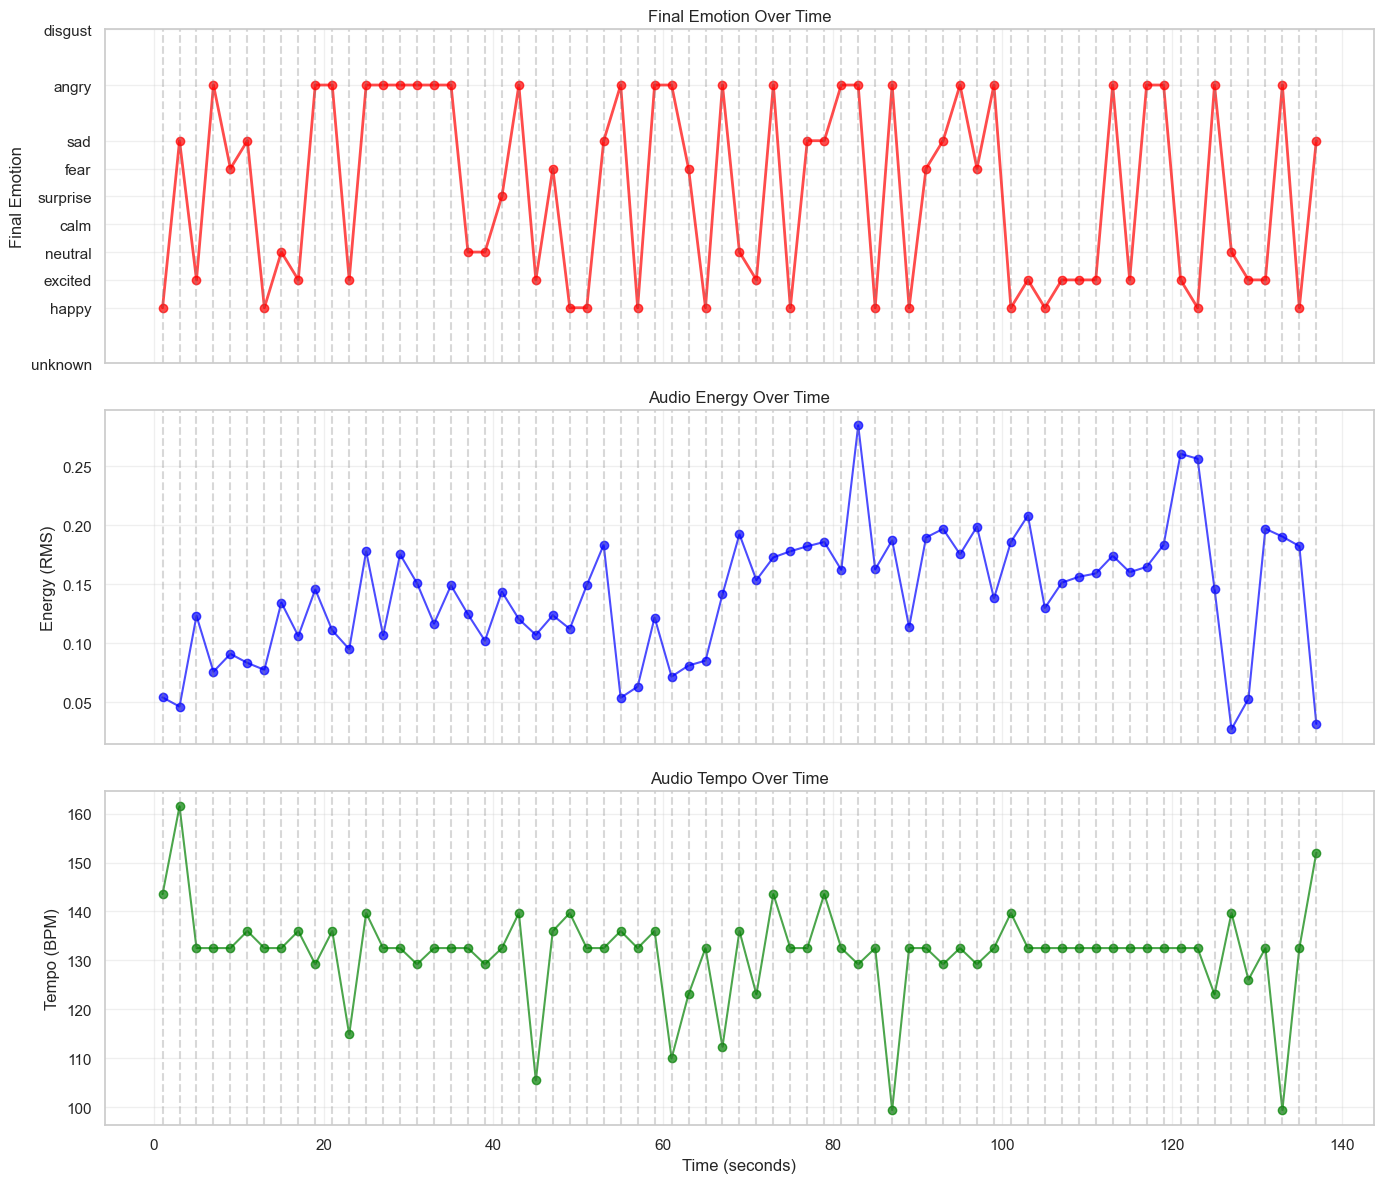

In [9]:
# Create a figure with multiple subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12), sharex=True)

# Plot Final Emotion on the first subplot
ax1.plot(
    timeline_df['timestamp'], 
    timeline_df['final_emotion_value'], 
    'o-', 
    color='red', 
    linewidth=2,
    alpha=0.7
)
ax1.set_ylabel('Final Emotion')
ax1.set_title('Final Emotion Over Time')
ax1.set_yticks(emotion_ticks)
ax1.set_yticklabels(emotion_labels)
ax1.grid(True, alpha=0.3)

# Plot Energy on the second subplot
ax2.plot(
    timeline_df['timestamp'], 
    timeline_df['energy'], 
    'o-', 
    color='blue',
    alpha=0.7
)
ax2.set_ylabel('Energy (RMS)')
ax2.set_title('Audio Energy Over Time')
ax2.grid(True, alpha=0.3)

# Plot Tempo on the third subplot
ax3.plot(
    timeline_df['timestamp'], 
    timeline_df['tempo'], 
    'o-', 
    color='green',
    alpha=0.7
)
ax3.set_xlabel('Time (seconds)')
ax3.set_ylabel('Tempo (BPM)')
ax3.set_title('Audio Tempo Over Time')
ax3.grid(True, alpha=0.3)

# Show shot boundaries if available
if not timeline_df['shot_id'].isna().all():
    shot_changes = timeline_df[timeline_df['shot_id'].diff() != 0]
    for time in shot_changes['timestamp']:
        ax1.axvline(x=time, color='gray', linestyle='--', alpha=0.3)
        ax2.axvline(x=time, color='gray', linestyle='--', alpha=0.3)
        ax3.axvline(x=time, color='gray', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


### 4. Correlation Between Features

Let's examine the correlation between different features:

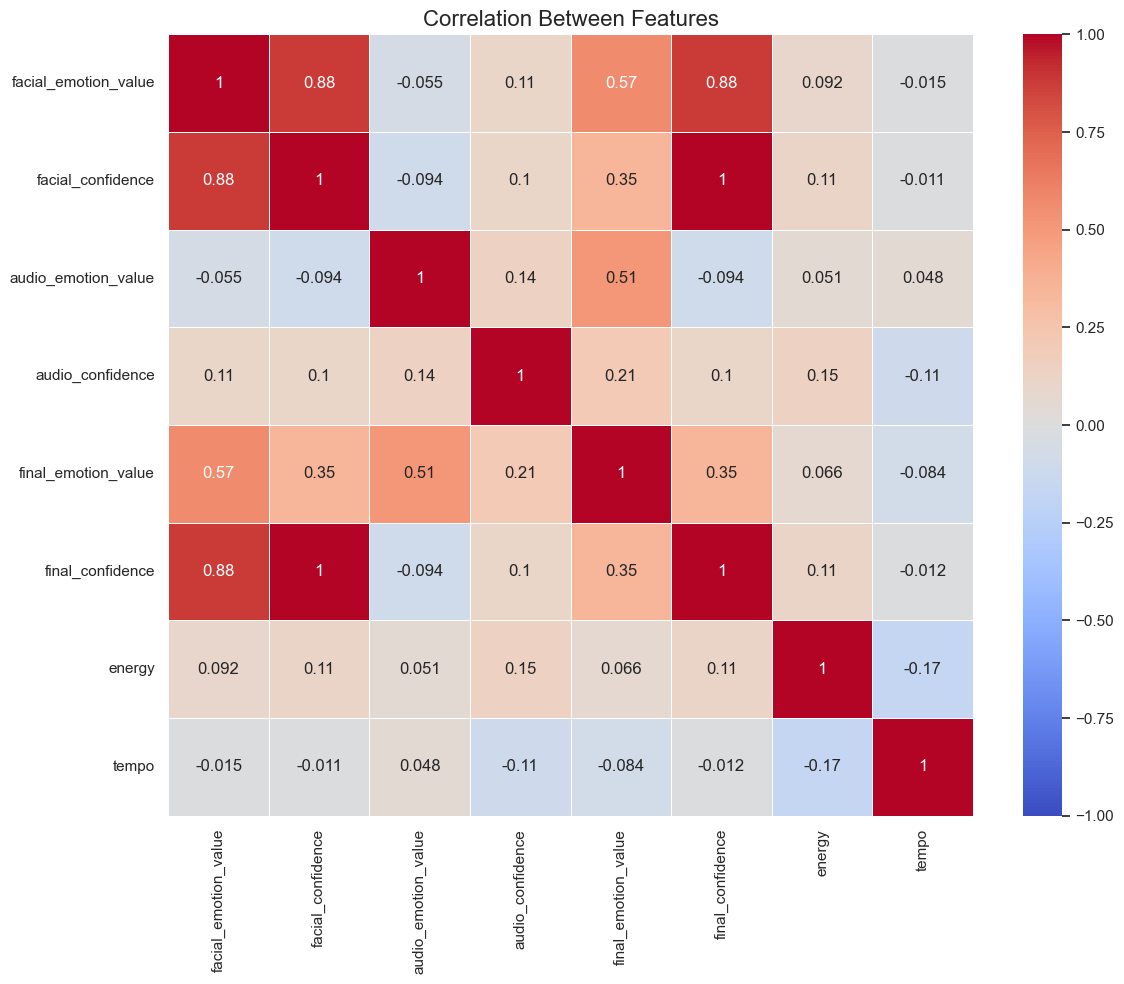

In [10]:
# Select numerical columns for correlation
corr_columns = [
    'facial_emotion_value', 'facial_confidence',
    'audio_emotion_value', 'audio_confidence',
    'final_emotion_value', 'final_confidence',
    'energy', 'tempo'
]

# Calculate correlation matrix
corr_df = timeline_df[corr_columns].corr()

# Create correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_df, 
    annot=True, 
    cmap='coolwarm', 
    vmin=-1, 
    vmax=1, 
    linewidths=.5
)
plt.title('Correlation Between Features', fontsize=16)
plt.tight_layout()
plt.show()


## Interpretation and Fusion Strategy

### Fusion Strategy
In this analysis, we merged facial and audio emotion data using the following approach:

1. **Timeline Construction**: We used the audio analysis timeline (typically more granular) as our base.
2. **Emotion Mapping**: For each time segment, we mapped facial emotions from overlapping shots.
3. **Final Emotion Selection**: When both facial and audio emotions were available, we selected the one with higher confidence as the "final emotion."
4. **Shot Boundaries**: We marked shot boundaries to understand how emotions change with visual cuts.

### Interpreting the Visualizations

The visualizations reveal several insights:

1. **Emotion Progression**: The line chart shows how emotions evolve throughout the trailer, revealing its emotional arc.
2. **Emotional Distribution**: The heatmap illustrates which emotions dominate in different parts of the trailer.
3. **Audio-Visual Relationship**: The overlaid charts of emotion, energy, and tempo show how audio characteristics correlate with emotional content.
4. **Correlation Analysis**: The correlation matrix helps understand relationships between different features.

### Using This Timeline for Feedback

This unified timeline can be used to provide feedback on movie trailers in several ways:

1. **Emotional Impact Assessment**: Evaluate if the trailer achieves its intended emotional impact by examining the dominant emotions.
2. **Pacing Analysis**: By examining how emotions change with tempo and energy, assess if the pacing feels appropriate.
3. **Editing Suggestions**: Identify segments where audio and visual emotions conflict unintentionally.
4. **Highlight Identification**: Locate emotionally powerful moments that could be emphasized or repositioned.
5. **Target Audience Alignment**: Determine if the emotional journey aligns with the target audience's preferences.

The timeline provides a data-driven approach to understand how a trailer's construction affects its emotional impact, which can guide refinements to enhance viewer engagement.